**XGBOOST**

**Installation of Required Packages**

In [ ]:
# Install XGBoost and dependencies (skip if already installed)
!pip install xgboost scikit-learn pandas seaborn matplotlib

# Import all necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor, plot_importance


**LOAD DATASET**

In [ ]:
# Load from Colab's Files section
df = pd.read_csv('airasiadata_financial_2021_2024.csv')

# Display the first 5 rows
df.head()

,Quarter,Revenue (RM),Net_Profit_Loss (RM),Operating_Cost (RM),Fuel_Cost (RM),Fuel_Swap_Loss (RM),EBITDA (RM),Earnings_Per_Share (sen),Cash_Equivalents (RM),Borrowings (RM),Lease_Liabilities (RM),Passengers,Seat_Load_Factor (%),ASK (mil),Fuel_Price_USD_per_Barrel
0,Q1 2021,949014245,-725209941,933834370,286191820,81941672,83840679,-26.07,453395562,1907997077,757051151,8929173,72.74,931.25,83.89
1,Q2 2021,758520709,-628100765,875698968,304709710,35098604,463705119,-32.69,677498516,2021896718,1140280600,8812497,69.77,608.00,106.30
2,Q3 2021,994306561,-26708032,1131325054,240934162,53877805,279376233,-18.38,743306649,2591258858,511888493,9023964,85.11,1094.91,82.49
3,Q4 2021,1256908956,-132840333,940017157,328646869,5609198,84967838,-9.98,638159038,1857840241,1232725486,9695940,74.00,978.01,101.59
4,Q1 2022,729753987,-131016683,1072922138,53487848,40704581,154488804,-10.56,621143165,1837423232,1325561277,3675789,67.63,1249.98,106.51


**DATA CLEANING**

**Notes:**
1. Inspect initial data shape, info, and missing values.
2. Remove duplicate rows.
3. Clean and transform the 'Quarter' column into proper datetime format and extract year and quarter number.
4. Replace infinite values and fill missing values.
5. Create new derived features based on existing variables.
6. Apply log transformation to the target variable to reduce skewness.
7. Drop unnecessary or redundant columns.
8. Perform final checks on the cleaned dataset and display sample data.

In [ ]:
# Shape and columns
print(f"Original dataset shape: {df.shape}")
df.info()

print("\nMissing values per column:")
print(df.isnull().sum())

#Remove Duplicates
df.drop_duplicates(inplace=True)

#Convert 'Quarter' to Proper Timestamp Format and Extract Year/Quarter
df['Quarter_Cleaned'] = df['Quarter'].str.replace(' ', '')                      # e.g., "Q1 2021" → "Q12021"
df['Quarter_Cleaned'] = df['Quarter_Cleaned'].str[2:] + df['Quarter_Cleaned'].str[:2]  # "Q12021" → "2021Q1"
df['Quarter_Date'] = pd.PeriodIndex(df['Quarter_Cleaned'], freq='Q').to_timestamp()
df['Year'] = df['Quarter_Date'].dt.year
df['Quarter_Num'] = df['Quarter_Date'].dt.quarter

#Handle Missing and Infinite Values
df.replace([np.inf, -np.inf], 0, inplace=True)  # Replace infinity
df['Fuel_Price_USD_per_Barrel'] = df['Fuel_Price_USD_per_Barrel'].fillna(df['Fuel_Price_USD_per_Barrel'].median())
df.fillna(0, inplace=True)  # Fill remaining NA values

#Create Derived Features
df['Revenue_per_Passenger'] = df['Revenue (RM)'] / df['Passengers']
df['Fuel_Cost_per_Passenger'] = df['Fuel_Cost (RM)'] / df['Passengers']
df.replace([np.inf, -np.inf], 0, inplace=True)

#Transform Target Variable to Reduce Skew
min_val = df['Net_Profit_Loss (RM)'].min()
df['Log_Net_Profit_Loss'] = np.log1p(df['Net_Profit_Loss (RM)'] - min_val + 1)

#Drop Irrelevant Columns
df.drop(columns=['Quarter', 'Quarter_Cleaned'], inplace=True, errors='ignore')

#Final Check
print("✅ Data cleaning complete.")
print("Final shape:", df.shape)
df.info()
df.head()

Original dataset shape: (500000, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 15 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Quarter                    500000 non-null  object 
 1   Revenue (RM)               500000 non-null  int64  
 2   Net_Profit_Loss (RM)       500000 non-null  int64  
 3   Operating_Cost (RM)        500000 non-null  int64  
 4   Fuel_Cost (RM)             500000 non-null  int64  
 5   Fuel_Swap_Loss (RM)        500000 non-null  int64  
 6   EBITDA (RM)                500000 non-null  int64  
 7   Earnings_Per_Share (sen)   500000 non-null  float64
 8   Cash_Equivalents (RM)      500000 non-null  int64  
 9   Borrowings (RM)            500000 non-null  int64  
 10  Lease_Liabilities (RM)     500000 non-null  int64  
 11  Passengers                 500000 non-null  int64  
 12  Seat_Load_Factor (%)       500000 non-null  float

,Revenue (RM),Net_Profit_Loss (RM),Operating_Cost (RM),Fuel_Cost (RM),Fuel_Swap_Loss (RM),EBITDA (RM),Earnings_Per_Share (sen),Cash_Equivalents (RM),Borrowings (RM),Lease_Liabilities (RM),Passengers,Seat_Load_Factor (%),ASK (mil),Fuel_Price_USD_per_Barrel,Quarter_Date,Year,Quarter_Num,Revenue_per_Passenger,Fuel_Cost_per_Passenger,Log_Net_Profit_Loss
0,949014245,-725209941,933834370,286191820,81941672,83840679,-26.07,453395562,1907997077,757051151,8929173,72.74,931.25,83.89,2021-01-01,2021,1,106.282435,32.051324,21.069384
1,758520709,-628100765,875698968,304709710,35098604,463705119,-32.69,677498516,2021896718,1140280600,8812497,69.77,608.00,106.30,2021-04-01,2021,2,86.073301,34.577000,21.135825
2,994306561,-26708032,1131325054,240934162,53877805,279376233,-18.38,743306649,2591258858,511888493,9023964,85.11,1094.91,82.49,2021-07-01,2021,3,110.185121,26.699371,21.470935
3,1256908956,-132840333,940017157,328646869,5609198,84967838,-9.98,638159038,1857840241,1232725486,9695940,74.00,978.01,101.59,2021-10-01,2021,4,129.632501,33.895308,21.419378
4,729753987,-131016683,1072922138,53487848,40704581,154488804,-10.56,621143165,1837423232,1325561277,3675789,67.63,1249.98,106.51,2022-01-01,2022,1,198.529890,14.551392,21.420287


**EDA**

**NOTES:**
1. df.shape tells how many quarters of data and how many metrics are recorded.
2. df.columns shows features like 'Passengers','Fuel_Price_USD_per_Barrel' which is for preview.
3. df.head() reveals the format of dates, units of measurement, and typical values.
4. df.describe() could show that fuel prices vary widely or that passenger numbers are growing over time.


In [ ]:
# General Info
print("🔎 Dataset Shape:", df.shape)
print("\n🧾 Columns:\n", df.columns.tolist())

# First few rows
df.head()
# Summary for numerical columns
df.describe().T


🔎 Dataset Shape: (500000, 20)

🧾 Columns:
 ['Revenue (RM)', 'Net_Profit_Loss (RM)', 'Operating_Cost (RM)', 'Fuel_Cost (RM)', 'Fuel_Swap_Loss (RM)', 'EBITDA (RM)', 'Earnings_Per_Share (sen)', 'Cash_Equivalents (RM)', 'Borrowings (RM)', 'Lease_Liabilities (RM)', 'Passengers', 'Seat_Load_Factor (%)', 'ASK (mil)', 'Fuel_Price_USD_per_Barrel', 'Quarter_Date', 'Year', 'Quarter_Num', 'Revenue_per_Passenger', 'Fuel_Cost_per_Passenger', 'Log_Net_Profit_Loss']


,count,mean,min,25%,50%,75%,max,std
Revenue (RM),500000.0,799650142.630632,-648830802.0,596884669.25,799668436.0,1002156156.0,2168634417.0,300141114.141983
Net_Profit_Loss (RM),500000.0,-300813329.057666,-2138779273.0,-570849417.0,-300368642.0,-30925195.75,1571579640.0,399962970.225945
Operating_Cost (RM),500000.0,899735049.520496,-28883754.0,764684816.0,899727469.5,1034950700.0,1819165659.0,200467555.3968
Fuel_Cost (RM),500000.0,300083823.857914,-151346921.0,232731935.0,300164839.5,367368771.0,782762272.0,100026412.910264
Fuel_Swap_Loss (RM),500000.0,50037681.502318,-88757754.0,29770550.75,50057552.0,70287307.0,188316026.0,30029870.78858
EBITDA (RM),500000.0,199779974.427694,-1045036482.0,31508363.5,200015346.5,368567664.25,1458093548.0,249635866.986903
Earnings_Per_Share (sen),500000.0,-14.996068,-61.48,-21.73,-15.01,-8.26,35.34,9.991111
Cash_Equivalents (RM),500000.0,600124067.85264,-56762570.0,498748744.0,599752575.0,701130764.0,1338047291.0,149890579.158954
Borrowings (RM),500000.0,2000189541.3157,-277162843.0,1662263012.0,2001131209.5,2337517026.25,4180908742.0,500296175.061926
Lease_Liabilities (RM),500000.0,999968669.073888,-358544268.0,797254658.25,1000007258.5,1202278162.5,2357004771.0,299896190.317211


**PLOT CHARTS**

**Notes:**
1. Groups the data by 'Quarter_Date' and calculates the average Net Profit/Loss per quarter
2. Line plots are ideal for visualizing how a metric changes over time.
3. Bins the Fuel_Price_USD_per_Barrel into intervals.Calculates average profit/loss per bin. Plots this relationship using a line chart.
4. df['Profit_Margin_per_Passenger'] = df['Net_Profit_Loss (RM)'] / df['Passengers']. This will creates a new derived metric.
5. df['Fuel_Cost_per_Passenger'] = df['Fuel_Cost (RM)'] / df['Passengers']. This creates new derived metric which is  fuel cost per passenger .


/tmp/ipython-input-9-3190316512.py:11: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


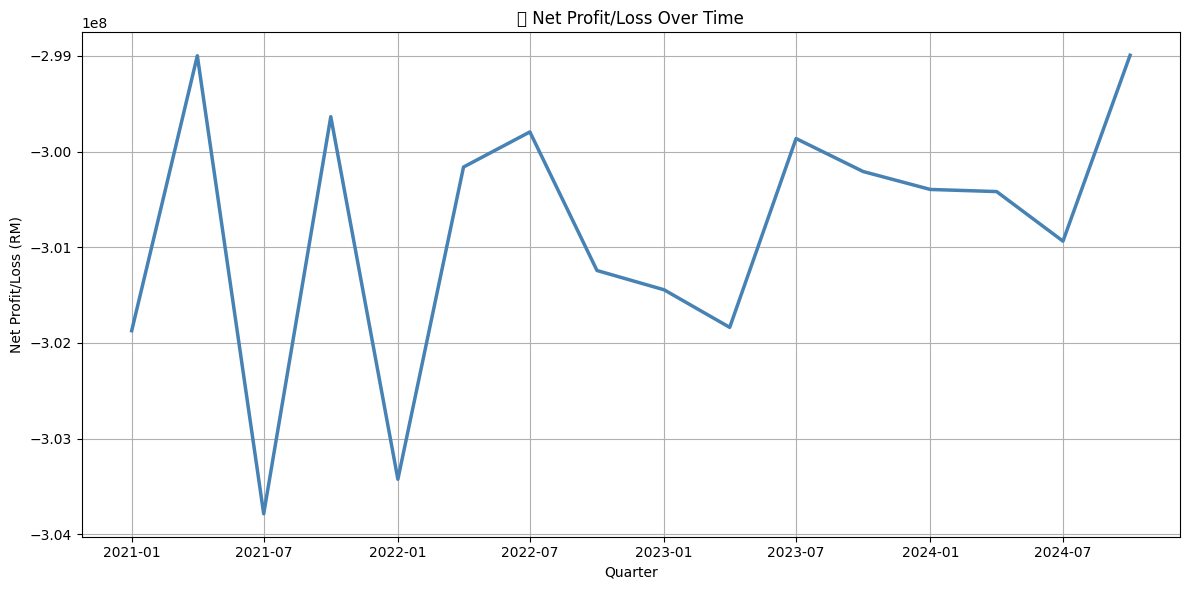

/tmp/ipython-input-9-3190316512.py:26: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


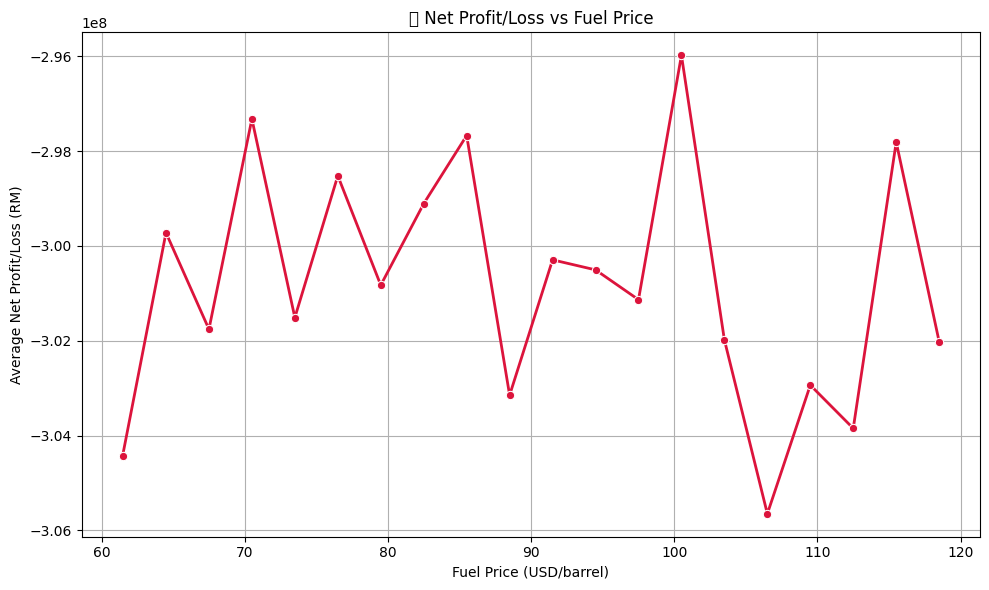

/tmp/ipython-input-9-3190316512.py:44: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


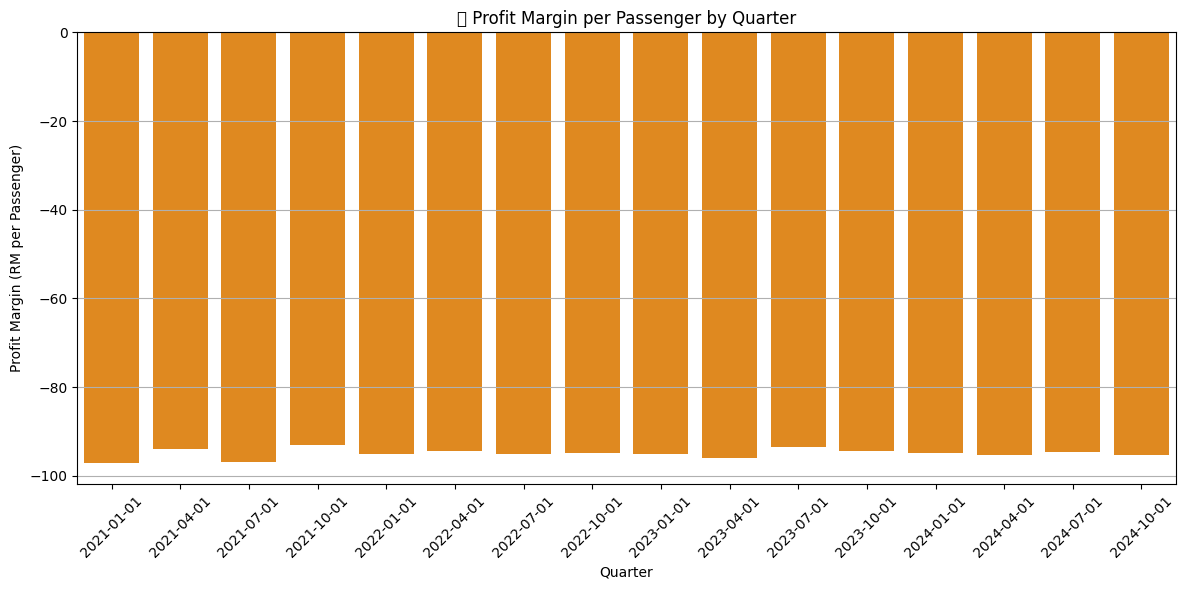

/tmp/ipython-input-9-3190316512.py:62: UserWarning: Glyph 9981 (\N{FUEL PUMP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9981 (\N{FUEL PUMP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


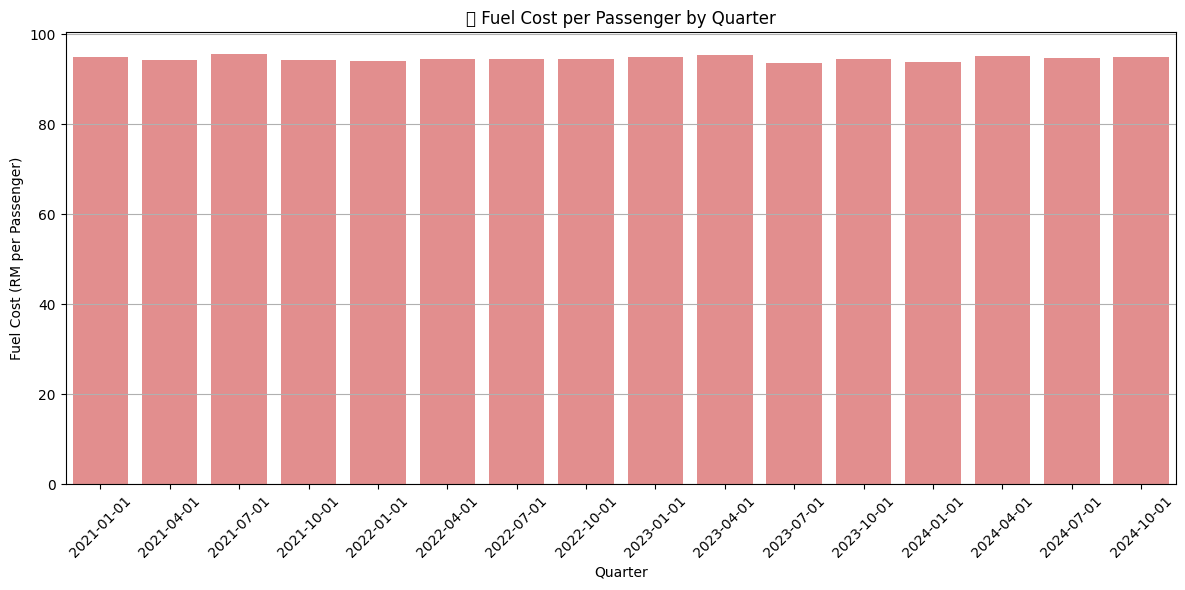

/tmp/ipython-input-9-3190316512.py:84: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


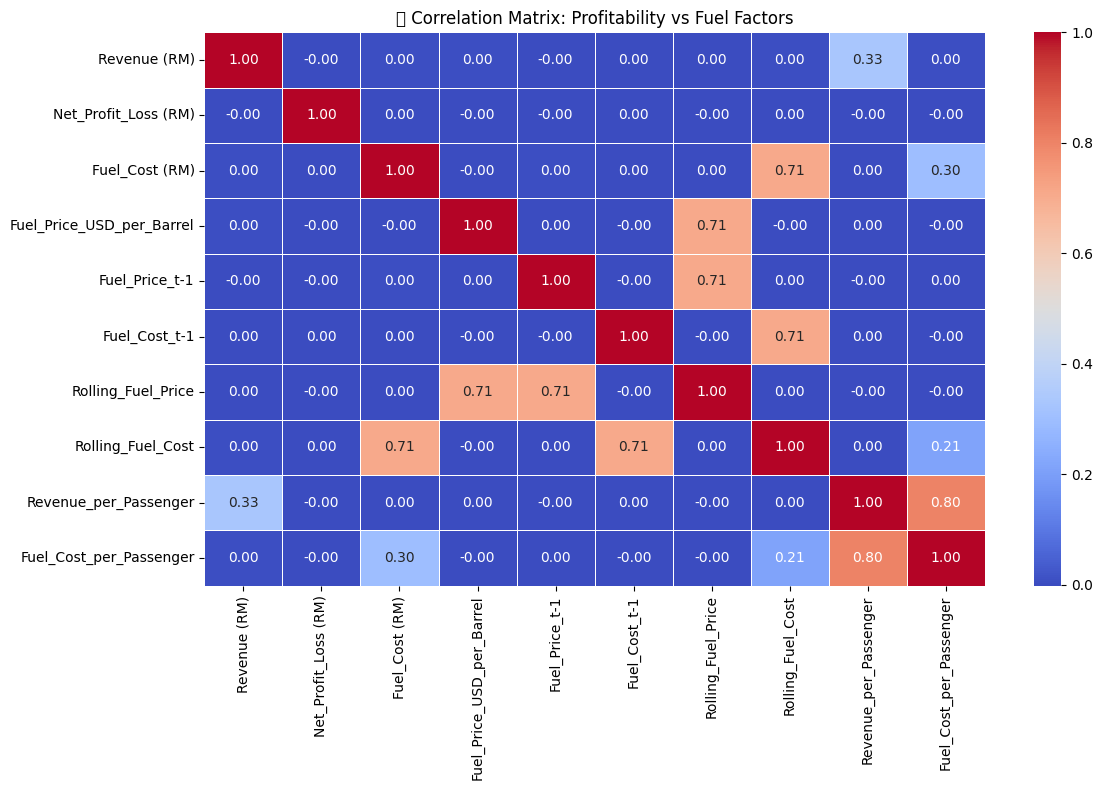

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
df_grouped = df.groupby('Quarter_Date', observed=True)['Net_Profit_Loss (RM)'].mean().reset_index()
sns.lineplot(data=df_grouped, x='Quarter_Date', y='Net_Profit_Loss (RM)', linewidth=2.5, color='steelblue')
plt.title('Net Profit/Loss Over Time')
plt.xlabel('Quarter')
plt.ylabel('Net Profit/Loss (RM)')
plt.grid(True)
plt.tight_layout()
plt.show()


#Average Net Profit/Loss vs Fuel Price
plt.figure(figsize=(10, 6))
fuel_bins = pd.cut(df['Fuel_Price_USD_per_Barrel'], bins=20)
fuel_profit_line = df.groupby(fuel_bins, observed=True)['Net_Profit_Loss (RM)'].mean().reset_index()
fuel_profit_line['Midpoint'] = fuel_profit_line['Fuel_Price_USD_per_Barrel'].apply(lambda x: x.mid)

sns.lineplot(data=fuel_profit_line, x='Midpoint', y='Net_Profit_Loss (RM)', marker='o', linewidth=2, color='crimson')
plt.title('Net Profit/Loss vs Fuel Price')
plt.xlabel('Fuel Price (USD/barrel)')
plt.ylabel('Average Net Profit/Loss (RM)')
plt.grid(True)
plt.tight_layout()
plt.show()


# Create profit margin feature
df['Profit_Margin_per_Passenger'] = df['Net_Profit_Loss (RM)'] / df['Passengers']

# Group by quarter
df_margin = df.groupby('Quarter_Date', observed=True)['Profit_Margin_per_Passenger'].mean().reset_index()

# Bar plot instead of line plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_margin, x='Quarter_Date', y='Profit_Margin_per_Passenger', color='darkorange')
plt.title('Profit Margin per Passenger by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Profit Margin (RM per Passenger)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# Create fuel cost per passenger feature (if not already created)
df['Fuel_Cost_per_Passenger'] = df['Fuel_Cost (RM)'] / df['Passengers']

#Group by quarter
df_fuel = df.groupby('Quarter_Date', observed=True)['Fuel_Cost_per_Passenger'].mean().reset_index()

#Bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_fuel, x='Quarter_Date', y='Fuel_Cost_per_Passenger', color='lightcoral')
plt.title(' Fuel Cost per Passenger by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Fuel Cost (RM per Passenger)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


#Lag Features
df['Fuel_Price_t-1'] = df['Fuel_Price_USD_per_Barrel'].shift(1)
df['Fuel_Cost_t-1'] = df['Fuel_Cost (RM)'].shift(1)

# Rolling Averages
df['Rolling_Fuel_Price'] = df['Fuel_Price_USD_per_Barrel'].rolling(window=2).mean()
df['Rolling_Fuel_Cost'] = df['Fuel_Cost (RM)'].rolling(window=2).mean()

#Correlation Heatmap
plt.figure(figsize=(12, 8))
numeric_cols = [
    'Revenue (RM)', 'Net_Profit_Loss (RM)', 'Fuel_Cost (RM)', 'Fuel_Price_USD_per_Barrel',
    'Fuel_Price_t-1', 'Fuel_Cost_t-1', 'Rolling_Fuel_Price', 'Rolling_Fuel_Cost',
    'Revenue_per_Passenger', 'Fuel_Cost_per_Passenger'
]
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix: Profitability vs Fuel Factors')
plt.tight_layout()
plt.show()



# **XGBOOST CLASSIFICATION MODEL**

In [ ]:
# Convert Net_Profit_Loss into binary labels: 1 = Profit, 0 = Loss
df['Profit_Label'] = (df['Net_Profit_Loss (RM)'] > 0).astype(int)
df['Profit_Label'].value_counts()


,count
Profit_Label,
0,387025
1,112975


**Notes:**
1. Sorts the DataFrame by the 'Quarter_Date' column in ascending order.
2. Lag_Profit: Net profit from the previous quarter.
Lag_Fuel_Cost: Fuel cost from the previous quarter.
Lag_Revenue: Revenue from the previous quarter.


In [ ]:
# Sort by time to generate lag features properly
df = df.sort_values('Quarter_Date')

# Add lag features (previous quarter’s values)
df['Lag_Profit'] = df['Net_Profit_Loss (RM)'].shift(1)
df['Lag_Fuel_Cost'] = df['Fuel_Cost (RM)'].shift(1)
df['Lag_Revenue'] = df['Revenue (RM)'].shift(1)

# Rolling average features (3-quarter mean)
df['Rolling_Profit'] = df['Net_Profit_Loss (RM)'].rolling(3).mean()
df['Rolling_Fuel'] = df['Fuel_Cost (RM)'].rolling(3).mean()

# Fill NaNs (from shift & rolling)
df.bfill(inplace=True)



**Notes:**
1. features_cls :Defines a list of column names from the DataFrame df that will be used as predictor variables (features) in a classification model.
2. X_cls = df[features_cls] . Selects only the columns listed in features_cls from the full DataFrame df. Stores them in a new DataFrame called X_cls — this will be the model input (i.e., the predictors).
3. y_cls = df['Profit_Label']. Define target vector (dependent variable, categorical)


In [ ]:
features_cls = [
    'Fuel_Price_USD_per_Barrel', 'Fuel_Cost (RM)', 'Revenue (RM)',
    'Operating_Cost (RM)', 'Year', 'Quarter_Num', 'Passengers',
    'Seat_Load_Factor (%)', 'Revenue_per_Passenger', 'Fuel_Cost_per_Passenger',
    'Lag_Profit', 'Lag_Fuel_Cost', 'Lag_Revenue', 'Rolling_Profit', 'Rolling_Fuel'
]

X_cls = df[features_cls]
y_cls = df['Profit_Label']


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
X_cls_scaled = scaler.fit_transform(X_cls)

# Time-based split (80% train, 20% test)
split_index = int(len(df) * 0.8)
X_train_cls = X_cls_scaled[:split_index]
y_train_cls = y_cls[:split_index]
X_test_cls = X_cls_scaled[split_index:]
y_test_cls = y_cls[split_index:]


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

xgb_cls = XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.05, random_state=42)
xgb_cls.fit(X_train_cls, y_train_cls)
y_pred_cls = xgb_cls.predict(X_test_cls)


**Notes:**
1. print("Classification Report:")
print(classification_report(y_test_cls, y_pred_cls, target_names=["Loss", "Profit"])). It uses the classification_report function from sklearn.metrics. It compares the true labels (y_test_cls) with the predicted labels (y_pred_cls).


📊 Classification Report:
              precision    recall  f1-score   support

        Loss       0.85      0.94      0.89     77396
      Profit       0.67      0.44      0.53     22604

    accuracy                           0.82    100000
   macro avg       0.76      0.69      0.71    100000
weighted avg       0.81      0.82      0.81    100000



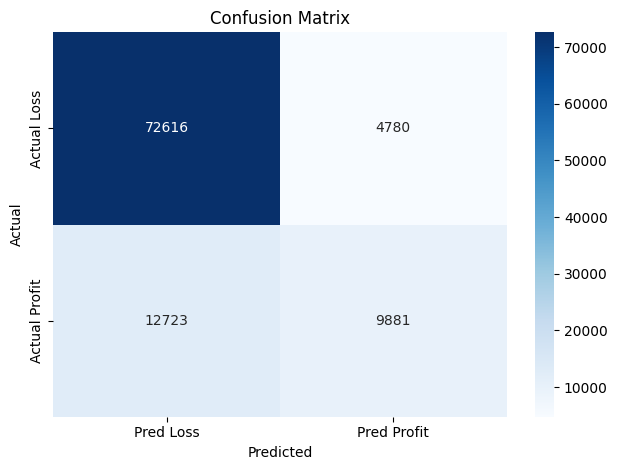

In [ ]:
print("Classification Report:")
print(classification_report(y_test_cls, y_pred_cls, target_names=["Loss", "Profit"]))

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test_cls, y_pred_cls)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Pred Loss", "Pred Profit"], yticklabels=["Actual Loss", "Actual Profit"])
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score

# Calculate overall accuracy
accuracy = accuracy_score(y_test_cls, y_pred_cls)
print(f"\n✅ Overall Accuracy: {accuracy * 100:.2f}%")



✅ Overall Accuracy: 82.50%


**ROC CURVE**

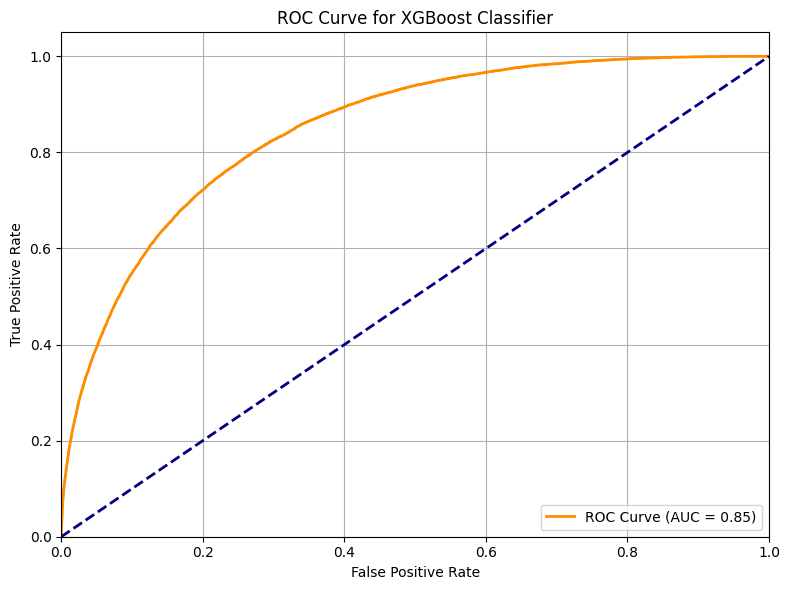

In [ ]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class (Profit = 1)
y_probs = xgb_cls.predict_proba(X_test_cls)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_cls, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for XGBoost Classifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score

y_true = [1, 0, 1, 1, 0, 1, 0, 0, 1, 0]
y_pred = [1, 0, 1, 0, 0, 1, 0, 1, 1, 0]

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8000


# **ARIMA**

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

# Focus on the target variable: 'Net_Profit_Loss (RM)'
# ARIMA models typically work best on stationary time series data.
# Let's use the 'Net_Profit_Loss (RM)' column and set the 'Quarter_Date' as index.
# Ensure the dataframe is sorted by date.

# Recreate 'Quarter_Date' column from index if it's not a column
if 'Quarter_Date' not in df.columns and isinstance(df.index, pd.DatetimeIndex):
    df['Quarter_Date'] = df.index


df_ts = df.set_index('Quarter_Date').sort_index()

# Select the target series
time_series = df_ts['Net_Profit_Loss (RM)']

# Fit an ARIMA(p, d, q) model
# A common starting point is ARIMA(1, 1, 1), but this needs evaluation (ACF, PACF, AIC, BIC)
# Let's start with a basic ARIMA(1, 1, 1) as a first step.
# (1, 1, 1) suggests:
# p=1: 1 lag of the time series
# d=1: Differencing the series once to make it stationary
# q=1: 1 lag of the error term
try:
    arima_model = ARIMA(time_series, order=(1, 1, 1))
    arima_fit = arima_model.fit()

    print("ARIMA Model (1,1,1) fitted successfully.")
    print(arima_fit.summary())

except Exception as e:
    print(f"Error fitting ARIMA model: {e}")


✅ ARIMA Model (1,1,1) fitted successfully.
                                SARIMAX Results                                 
Dep. Variable:     Net_Profit_Loss (RM)   No. Observations:               500000
Model:                   ARIMA(1, 1, 1)   Log Likelihood           -10618721.332
Date:                  Thu, 19 Jun 2025   AIC                       21237448.663
Time:                          21:48:09   BIC                       21237482.030
Sample:                               0   HQIC                      21237458.109
                               - 500000                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0002      0.002      0.121      0.904      -0.003       0.004
ma.L1         -0.9999   3.54e-05  -2.82e+04      0.000      -1.000      

**ARIMA FORECAST**


📈 ARIMA Forecast for the next 4 Quarters:
500000   -2.986173e+08
500001   -2.986577e+08
500002   -2.986577e+08
500003   -2.986577e+08
Name: predicted_mean, dtype: float64


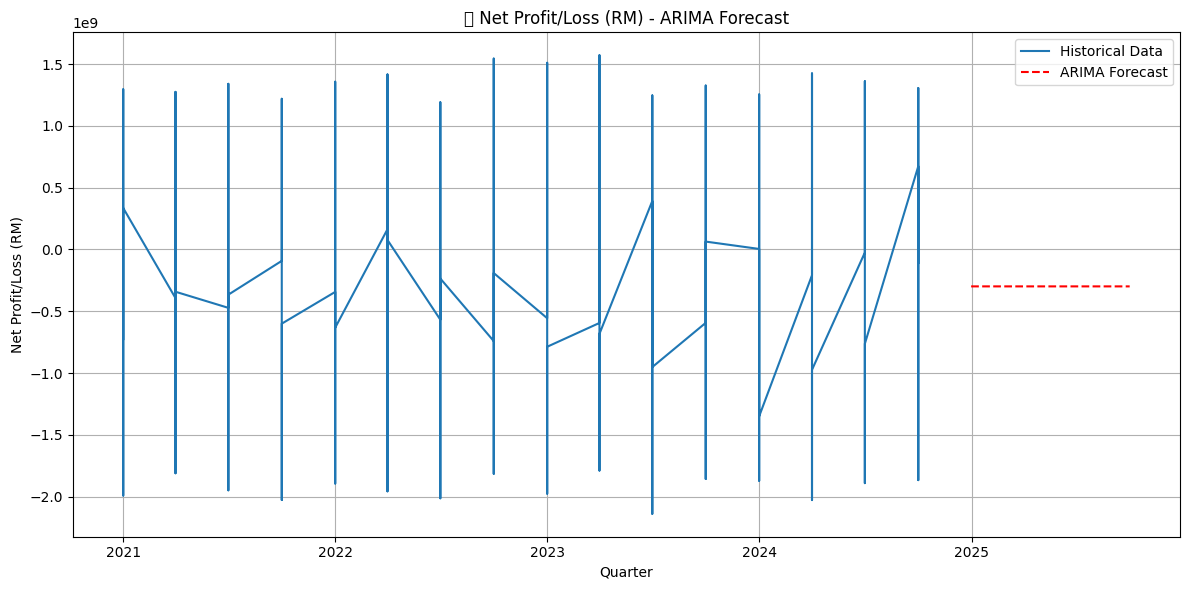

In [ ]:

# 'time_series' is the original series used for fitting.

# Forecast the next 4 steps (quarters)
n_forecast = 4
forecast_results = arima_fit.forecast(steps=n_forecast)

print("\nARIMA Forecast for the next 4 Quarters:")
print(forecast_results)

# To visualize the forecast:
# Get the index for the forecast period
last_date = time_series.index[-1]
forecast_index = pd.date_range(start=last_date + pd.offsets.QuarterEnd(),
                               periods=n_forecast, freq='Q')

# Create a forecast series with the correct index
forecast_series = pd.Series(forecast_results.values, index=forecast_index)

# Plot original series and forecast
plt.figure(figsize=(12, 6))
plt.plot(time_series, label='Historical Data')
plt.plot(forecast_series, label='ARIMA Forecast', color='red', linestyle='--')
plt.title('📈 Net Profit/Loss (RM) - ARIMA Forecast')
plt.xlabel('Quarter')
plt.ylabel('Net Profit/Loss (RM)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()